In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   siracusa
   2   oristano
   3   vercelli
   4   bari
   5   verbania
   6   pavia
   7   grosseto
   8   bergamo
   9   chieti
   10   brindisi
   11   padova
   12   brescia
   13   prato
   14   frosinone
   15   foggia
   16   terni
   17   ancona
   18   salerno
   19   pordenone
   20   trento
   21   torino
   22   imperia
   23   verona
   24   ascoli_piceno
   25   bolzano
   26   avellino
   27   crotone
   28   milano
   29   bat
   30   firenze
   31   sassari
   32   vicenza
   33   lucca
   34   caserta
   35   ravenna
   36   gorizia
   37   trieste
   38   taranto
   39   massa
   40   campobasso
   41   reggio_nell_emilia
   42   palermo
   43   napoli
   44   treviso
   45   genova
   46   rieti
   47   livorno
   48   rimini
   49   fermo
   50   udine
   51   cagliari
   52   pistoia
   53   lodi
   54   catania
   55   perugia
   56   macerata
   57   lecce
   58   potenza
   59   aless

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
           ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 siracusa
2 oristano
3 vercelli
4 bari
5 verbania
6 pavia
7 grosseto
8 bergamo
9 chieti
10 brindisi
11 padova
12 brescia
13 prato
14 frosinone
15 foggia
16 terni
17 ancona
18 salerno
19 pordenone
20 trento
21 torino
22 imperia
23 verona
24 ascoli_piceno
25 bolzano
26 avellino
27 crotone
28 milano
29 bat
30 firenze
31 sassari
32 vicenza
33 lucca
34 caserta
35 ravenna
36 gorizia
37 trieste
38 taranto
39 massa
40 campobasso
41 reggio_nell_emilia
42 palermo
43 napoli
44 treviso
45 genova
46 rieti
47 livorno
48 rimini
49 fermo
50 udine
51 cagliari
52 pistoia
53 lodi
54 catania
55 perugia
56 macerata
57 lecce
58 potenza
59 alessandria
60 reggio_di_calabria
61 varese
62 vibo_valentia
63 arezzo
64 trapani
65 la_spezia
66 teramo
67 lecco
68 monza
69 parma
70 novara
71 piacenza
72 modena
73 asti
74 cosenza
75 pesaro
76 viterbo
77 ferrara
78 enna
79 latina
80 matera
81 l_aquila
82 catanzaro
83 nuoro
84 mantova
85 sondrio
86 cuneo
87 siena
88 benevento
89 belluno
90 como
91 venezia
92 agrigento
9

In [4]:
#add random feature
import random

featurestobeused += ",randomfeature"
features_dict["randomfeature"] = np.zeros(len(ylogpropcasi), dtype="float64")

random.seed(1)
for i in range(len(ylogpropcasi)):
    features_dict["randomfeature"][i] = random.random()


In [5]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

A seguire i test cercando di minimizzare l'overfitting 

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.65182  0.03602 
    Test set average RMSE:  0.95357  0.08077 
             Fullset RMSE:  0.62860
                       R2:  0.81918


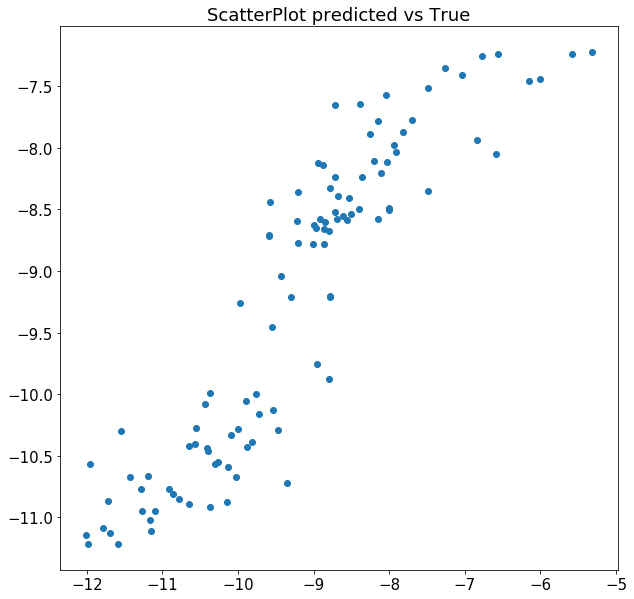

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04783 +/- 0.00467
Feature:               commutersdensity, Score: 0.02352 +/- 0.00294
Feature:                         depriv, Score: 0.04650 +/- 0.00440
Feature:                            lat, Score: 2.82693 +/- 0.36665
Feature:                 Ratio0200ver65, Score: 0.11891 +/- 0.01933
Feature:         avg_wpm10_period1_2020, Score: 0.19378 +/- 0.03108
Feature:           avg_wno_period1_2020, Score: 0.16906 +/- 0.02570
Feature:         avg_wpans_period1_2020, Score: 0.03786 +/- 0.00469
Feature:          avg_wso2_period1_2020, Score: 0.05631 +/- 0.01148
Feature:                  randomfeature, Score: 0.08874 +/- 0.01274


<Figure size 432x288 with 0 Axes>

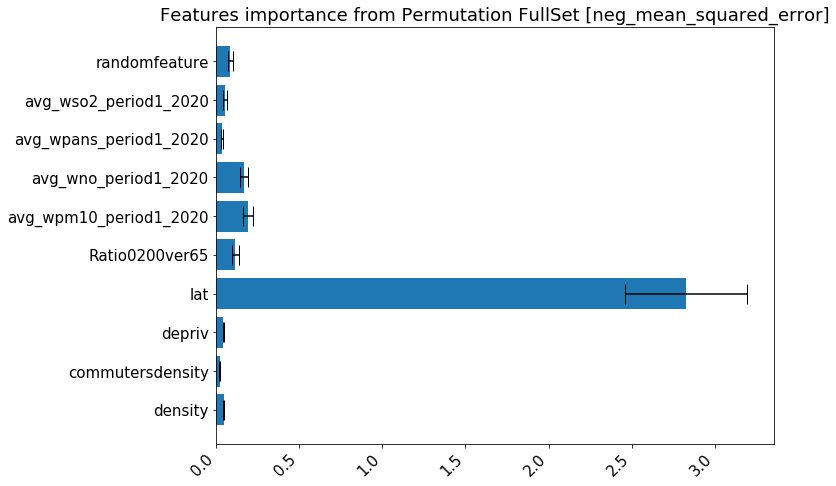

<Figure size 720x720 with 0 Axes>


Features importance from Permutation FullSet Score r2: 
Feature:                        density, Score: 0.02189 +/- 0.00214
Feature:               commutersdensity, Score: 0.01076 +/- 0.00135
Feature:                         depriv, Score: 0.02128 +/- 0.00201
Feature:                            lat, Score: 1.29364 +/- 0.16778
Feature:                 Ratio0200ver65, Score: 0.05442 +/- 0.00884
Feature:         avg_wpm10_period1_2020, Score: 0.08868 +/- 0.01422
Feature:           avg_wno_period1_2020, Score: 0.07736 +/- 0.01176
Feature:         avg_wpans_period1_2020, Score: 0.01732 +/- 0.00215
Feature:          avg_wso2_period1_2020, Score: 0.02577 +/- 0.00525
Feature:                  randomfeature, Score: 0.04061 +/- 0.00583


<Figure size 432x288 with 0 Axes>

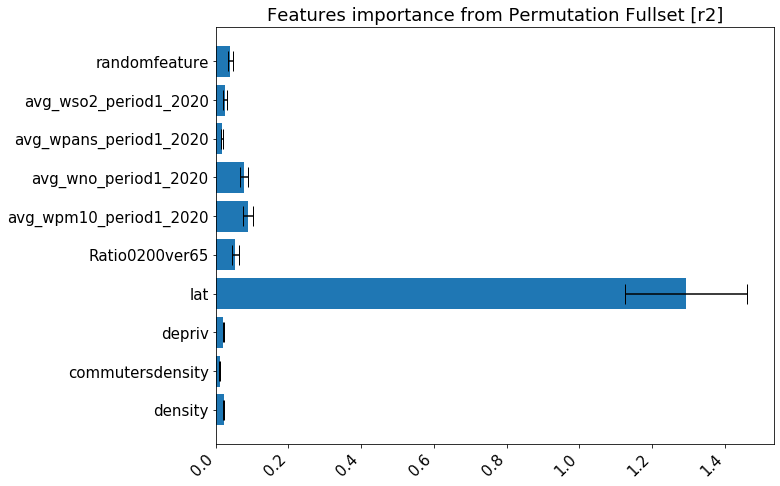

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.02284 +/- 0.01725
Feature:               commutersdensity, Score: -0.01481 +/- 0.01117
Feature:                         depriv, Score: -0.02253 +/- 0.03662
Feature:                            lat, Score: 2.73870 +/- 0.59003
Feature:                 Ratio0200ver65, Score: -0.02051 +/- 0.06835
Feature:         avg_wpm10_period1_2020, Score: -0.00693 +/- 0.02188
Feature:           avg_wno_period1_2020, Score: 0.06318 +/- 0.05393
Feature:         avg_wpans_period1_2020, Score: -0.00520 +/- 0.01487
Feature:          avg_wso2_period1_2020, Score: 0.00166 +/- 0.01423
Feature:                  randomfeature, Score: -0.00197 +/- 0.04963


<Figure size 432x288 with 0 Axes>

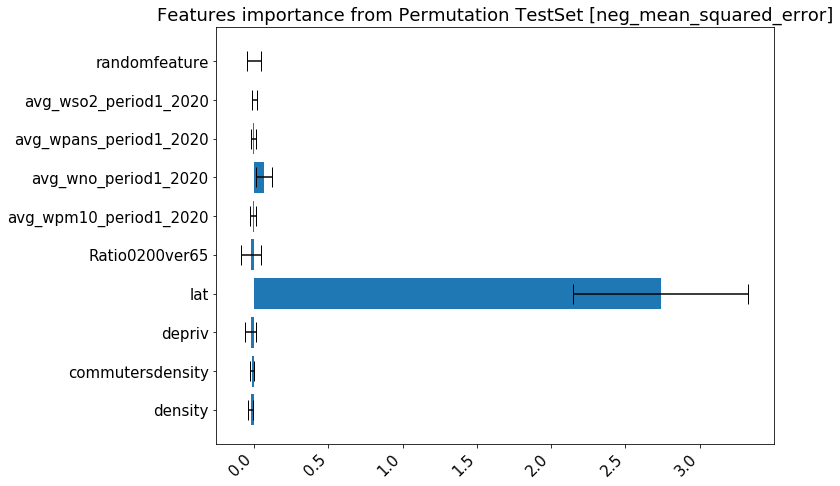

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.01187 +/- 0.00897
Feature:               commutersdensity, Score: -0.00770 +/- 0.00581
Feature:                         depriv, Score: -0.01172 +/- 0.01904
Feature:                            lat, Score: 1.42400 +/- 0.30679
Feature:                 Ratio0200ver65, Score: -0.01066 +/- 0.03554
Feature:         avg_wpm10_period1_2020, Score: -0.00360 +/- 0.01138
Feature:           avg_wno_period1_2020, Score: 0.03285 +/- 0.02804
Feature:         avg_wpans_period1_2020, Score: -0.00270 +/- 0.00773
Feature:          avg_wso2_period1_2020, Score: 0.00086 +/- 0.00740
Feature:                  randomfeature, Score: -0.00102 +/- 0.02580


<Figure size 432x288 with 0 Axes>

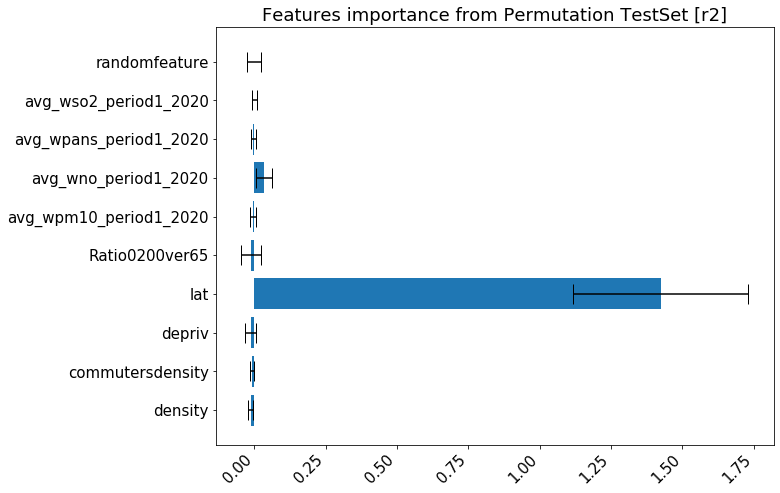

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04491 +/- 0.00777
Feature:               commutersdensity, Score: 0.01932 +/- 0.00271
Feature:                         depriv, Score: 0.06494 +/- 0.00720
Feature:                            lat, Score: 2.79112 +/- 0.36323
Feature:                 Ratio0200ver65, Score: 0.16478 +/- 0.02761
Feature:         avg_wpm10_period1_2020, Score: 0.13286 +/- 0.02288
Feature:           avg_wno_period1_2020, Score: 0.15033 +/- 0.03070
Feature:         avg_wpans_period1_2020, Score: 0.03772 +/- 0.00590
Feature:          avg_wso2_period1_2020, Score: 0.03841 +/- 0.00438
Feature:                  randomfeature, Score: 0.10827 +/- 0.01924


<Figure size 432x288 with 0 Axes>

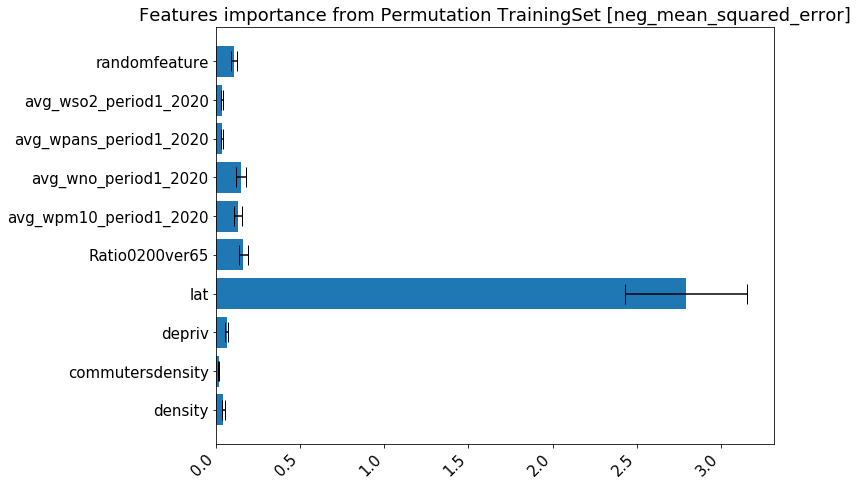

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        density, Score: 0.02073 +/- 0.00359
Feature:               commutersdensity, Score: 0.00892 +/- 0.00125
Feature:                         depriv, Score: 0.02998 +/- 0.00332
Feature:                            lat, Score: 1.28831 +/- 0.16766
Feature:                 Ratio0200ver65, Score: 0.07606 +/- 0.01275
Feature:         avg_wpm10_period1_2020, Score: 0.06132 +/- 0.01056
Feature:           avg_wno_period1_2020, Score: 0.06939 +/- 0.01417
Feature:         avg_wpans_period1_2020, Score: 0.01741 +/- 0.00273
Feature:          avg_wso2_period1_2020, Score: 0.01773 +/- 0.00202
Feature:                  randomfeature, Score: 0.04997 +/- 0.00888


<Figure size 432x288 with 0 Axes>

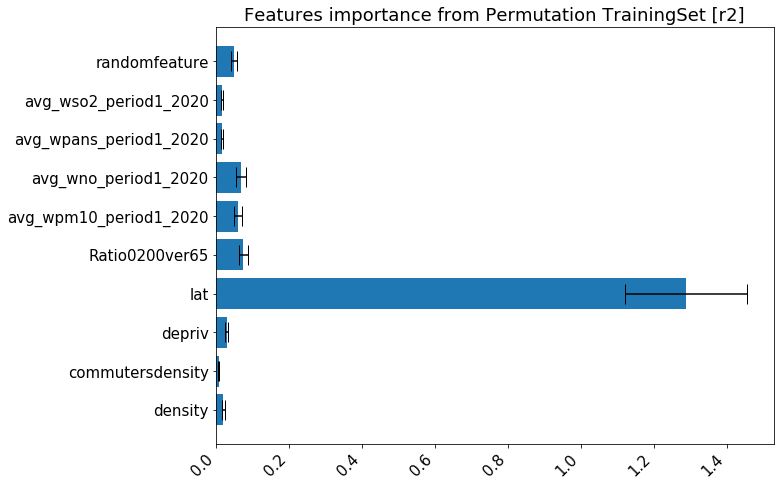

<Figure size 720x720 with 0 Axes>

In [6]:

importlib.reload(smlmodule)
import pprint

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_nooverfit (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
        smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
        plotname="rf_model_allfeatures_optoverfit", showplot=True, optimisedparams=besthyperF)

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 100,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  1.48303  0.07630 
    Test set average RMSE:  1.47122  0.14292 
             Fullset RMSE:  1.47826
                       R2: -0.00001


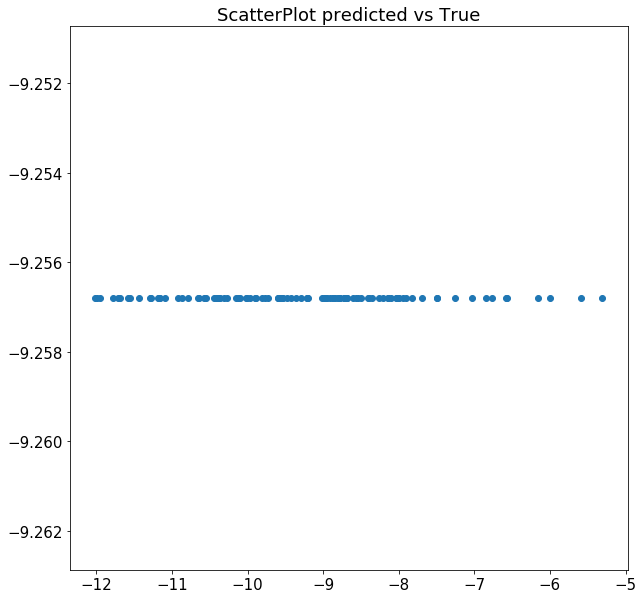

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05728 +/- 0.00683
Feature:               commutersdensity, Score: 1.61646 +/- 0.26525
Feature:                         depriv, Score: 0.07354 +/- 0.00883
Feature:                 Ratio0200ver65, Score: 0.22826 +/- 0.03285
Feature:         avg_wpm10_period1_2020, Score: 0.22557 +/- 0.03041
Feature:           avg_wno_period1_2020, Score: 0.38917 +/- 0.05035
Feature:         avg_wpans_period1_2020, Score: 0.06310 +/- 0.01059
Feature:          avg_wso2_period1_2020, Score: 0.08412 +/- 0.01064
Feature:                  randomfeature, Score: 0.09847 +/- 0.01427


<Figure size 432x288 with 0 Axes>

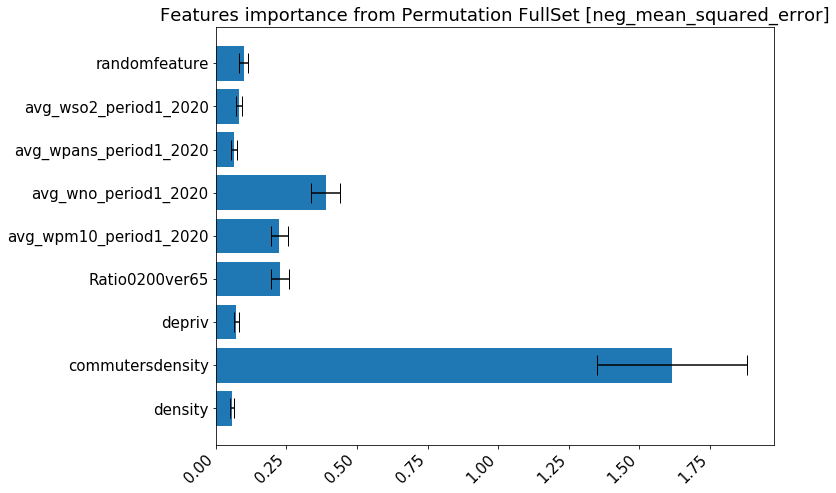

<Figure size 720x720 with 0 Axes>


Features importance from Permutation FullSet Score r2: 
Feature:                        density, Score: 0.02621 +/- 0.00313
Feature:               commutersdensity, Score: 0.73971 +/- 0.12138
Feature:                         depriv, Score: 0.03365 +/- 0.00404
Feature:                 Ratio0200ver65, Score: 0.10446 +/- 0.01503
Feature:         avg_wpm10_period1_2020, Score: 0.10322 +/- 0.01391
Feature:           avg_wno_period1_2020, Score: 0.17809 +/- 0.02304
Feature:         avg_wpans_period1_2020, Score: 0.02887 +/- 0.00485
Feature:          avg_wso2_period1_2020, Score: 0.03849 +/- 0.00487
Feature:                  randomfeature, Score: 0.04506 +/- 0.00653


<Figure size 432x288 with 0 Axes>

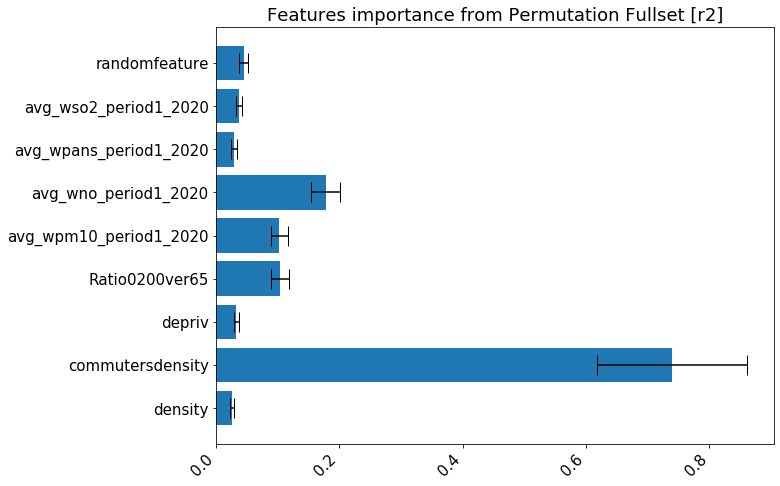

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.03479 +/- 0.02232
Feature:               commutersdensity, Score: 1.22108 +/- 0.39915
Feature:                         depriv, Score: -0.01105 +/- 0.03396
Feature:                 Ratio0200ver65, Score: 0.06541 +/- 0.09121
Feature:         avg_wpm10_period1_2020, Score: 0.04300 +/- 0.10162
Feature:           avg_wno_period1_2020, Score: 0.11848 +/- 0.15229
Feature:         avg_wpans_period1_2020, Score: 0.06659 +/- 0.05879
Feature:          avg_wso2_period1_2020, Score: 0.03218 +/- 0.02700
Feature:                  randomfeature, Score: -0.03096 +/- 0.04821


<Figure size 432x288 with 0 Axes>

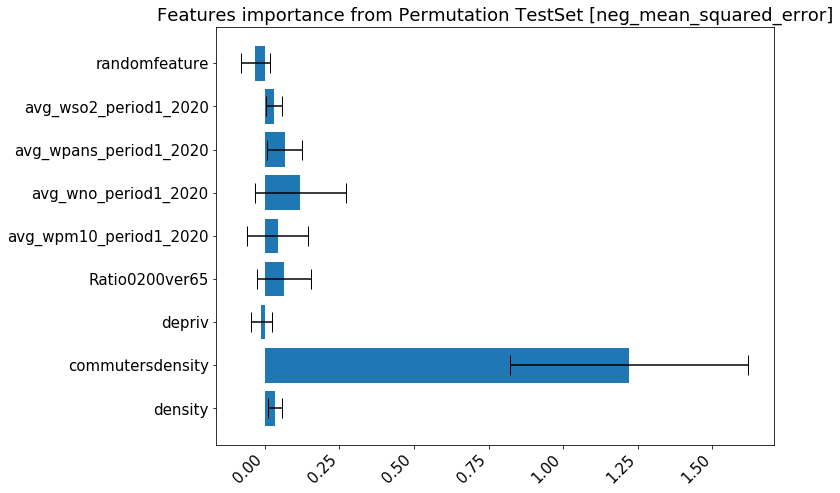

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: 0.01809 +/- 0.01160
Feature:               commutersdensity, Score: 0.63491 +/- 0.20754
Feature:                         depriv, Score: -0.00575 +/- 0.01766
Feature:                 Ratio0200ver65, Score: 0.03401 +/- 0.04743
Feature:         avg_wpm10_period1_2020, Score: 0.02236 +/- 0.05284
Feature:           avg_wno_period1_2020, Score: 0.06160 +/- 0.07918
Feature:         avg_wpans_period1_2020, Score: 0.03462 +/- 0.03057
Feature:          avg_wso2_period1_2020, Score: 0.01673 +/- 0.01404
Feature:                  randomfeature, Score: -0.01610 +/- 0.02507


<Figure size 432x288 with 0 Axes>

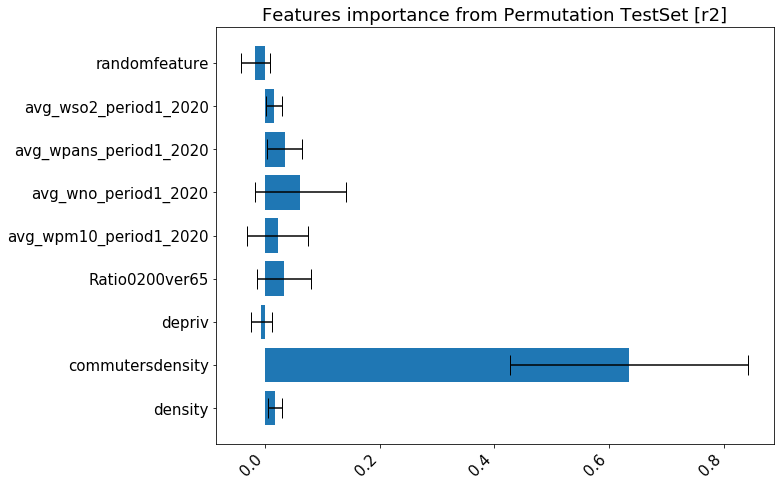

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05477 +/- 0.00894
Feature:               commutersdensity, Score: 1.57452 +/- 0.23140
Feature:                         depriv, Score: 0.07336 +/- 0.00713
Feature:                 Ratio0200ver65, Score: 0.22818 +/- 0.03428
Feature:         avg_wpm10_period1_2020, Score: 0.23215 +/- 0.03596
Feature:           avg_wno_period1_2020, Score: 0.31965 +/- 0.05620
Feature:         avg_wpans_period1_2020, Score: 0.05435 +/- 0.00883
Feature:          avg_wso2_period1_2020, Score: 0.04849 +/- 0.00576
Feature:                  randomfeature, Score: 0.12580 +/- 0.02322


<Figure size 432x288 with 0 Axes>

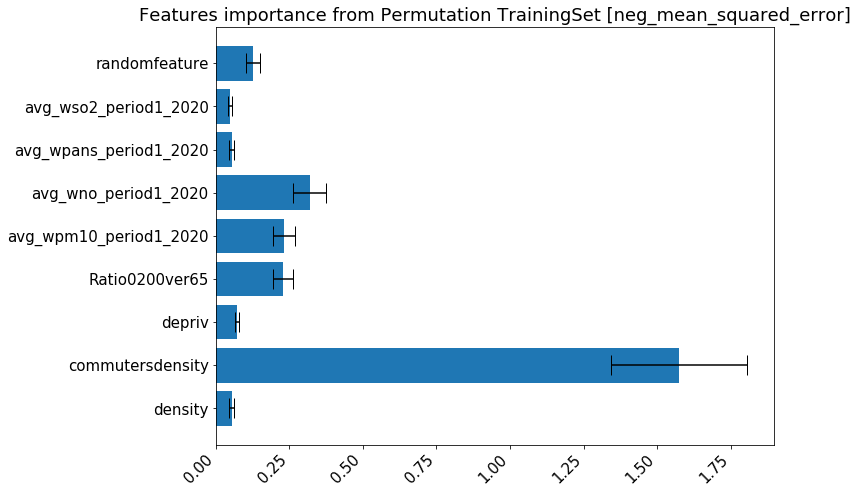

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        density, Score: 0.02528 +/- 0.00413
Feature:               commutersdensity, Score: 0.72676 +/- 0.10681
Feature:                         depriv, Score: 0.03386 +/- 0.00329
Feature:                 Ratio0200ver65, Score: 0.10532 +/- 0.01582
Feature:         avg_wpm10_period1_2020, Score: 0.10716 +/- 0.01660
Feature:           avg_wno_period1_2020, Score: 0.14754 +/- 0.02594
Feature:         avg_wpans_period1_2020, Score: 0.02509 +/- 0.00408
Feature:          avg_wso2_period1_2020, Score: 0.02238 +/- 0.00266
Feature:                  randomfeature, Score: 0.05807 +/- 0.01072


<Figure size 432x288 with 0 Axes>

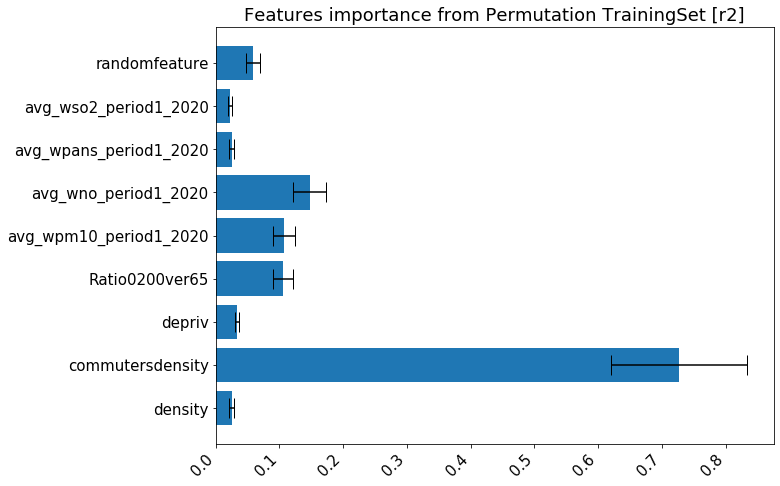

<Figure size 720x720 with 0 Axes>

In [7]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_nooverfit (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
    plotname="rf_model_nolat_optoverfit", showplot=True, optimisedparams=besthyperF )

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.77222  0.03788 
    Test set average RMSE:  1.09278  0.09437 
             Fullset RMSE:  0.72147
                       R2:  0.76181


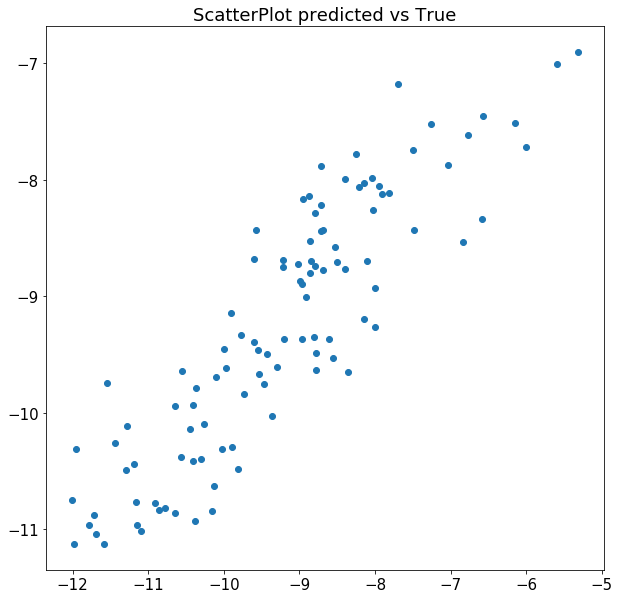

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        density, Score: 0.07100 +/- 0.00696
Feature:                         depriv, Score: 0.58538 +/- 0.09015
Feature:                 Ratio0200ver65, Score: 0.17734 +/- 0.02559
Feature:         avg_wpm10_period1_2020, Score: 0.46378 +/- 0.05153
Feature:           avg_wno_period1_2020, Score: 0.92809 +/- 0.11933
Feature:         avg_wpans_period1_2020, Score: 0.14029 +/- 0.01889
Feature:          avg_wso2_period1_2020, Score: 0.09060 +/- 0.00999
Feature:                  randomfeature, Score: 0.07673 +/- 0.01157


<Figure size 432x288 with 0 Axes>

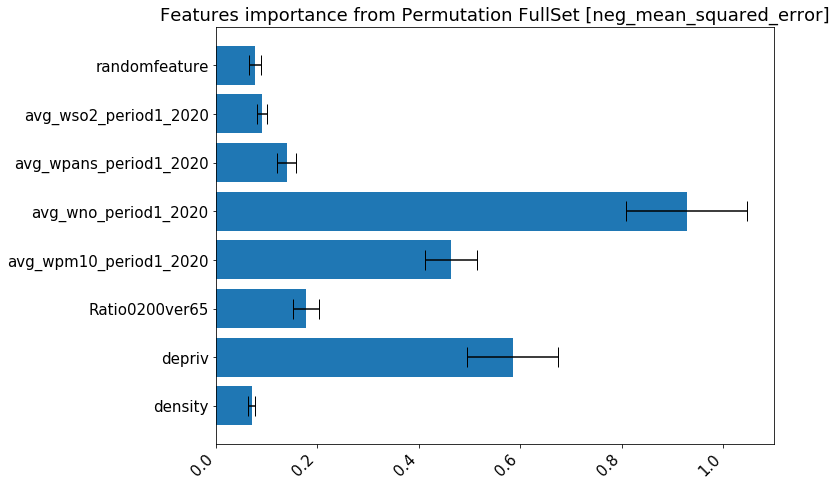

<Figure size 720x720 with 0 Axes>


Features importance from Permutation FullSet Score r2: 
Feature:                        density, Score: 0.03249 +/- 0.00318
Feature:                         depriv, Score: 0.26788 +/- 0.04125
Feature:                 Ratio0200ver65, Score: 0.08115 +/- 0.01171
Feature:         avg_wpm10_period1_2020, Score: 0.21223 +/- 0.02358
Feature:           avg_wno_period1_2020, Score: 0.42471 +/- 0.05461
Feature:         avg_wpans_period1_2020, Score: 0.06420 +/- 0.00864
Feature:          avg_wso2_period1_2020, Score: 0.04146 +/- 0.00457
Feature:                  randomfeature, Score: 0.03511 +/- 0.00529


<Figure size 432x288 with 0 Axes>

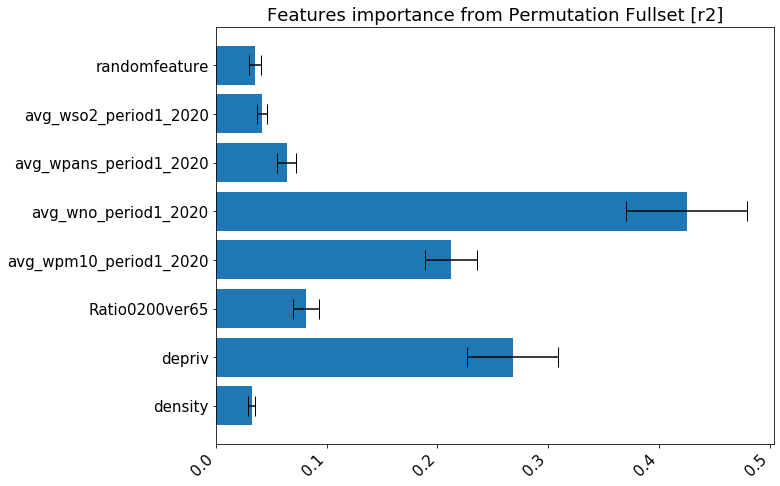

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.00867 +/- 0.02608
Feature:                         depriv, Score: 0.28589 +/- 0.23009
Feature:                 Ratio0200ver65, Score: -0.01634 +/- 0.05261
Feature:         avg_wpm10_period1_2020, Score: 0.12590 +/- 0.08301
Feature:           avg_wno_period1_2020, Score: 0.71365 +/- 0.32621
Feature:         avg_wpans_period1_2020, Score: -0.01381 +/- 0.06667
Feature:          avg_wso2_period1_2020, Score: 0.05058 +/- 0.03947
Feature:                  randomfeature, Score: -0.04785 +/- 0.05334


<Figure size 432x288 with 0 Axes>

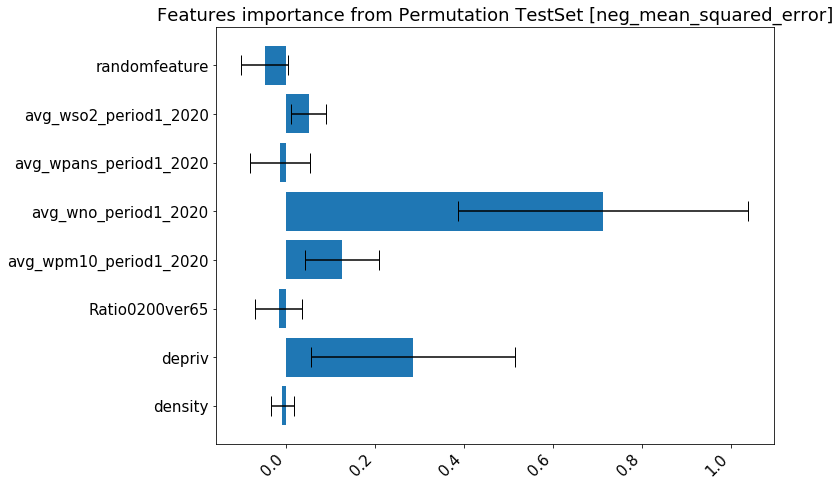

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.00451 +/- 0.01356
Feature:                         depriv, Score: 0.14865 +/- 0.11963
Feature:                 Ratio0200ver65, Score: -0.00849 +/- 0.02735
Feature:         avg_wpm10_period1_2020, Score: 0.06546 +/- 0.04316
Feature:           avg_wno_period1_2020, Score: 0.37107 +/- 0.16961
Feature:         avg_wpans_period1_2020, Score: -0.00718 +/- 0.03467
Feature:          avg_wso2_period1_2020, Score: 0.02630 +/- 0.02052
Feature:                  randomfeature, Score: -0.02488 +/- 0.02774


<Figure size 432x288 with 0 Axes>

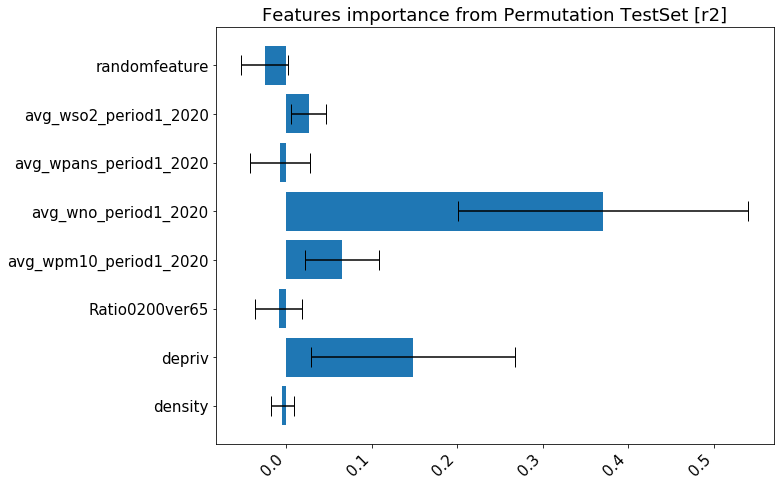

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.06362 +/- 0.01048
Feature:                         depriv, Score: 0.62895 +/- 0.08937
Feature:                 Ratio0200ver65, Score: 0.18893 +/- 0.02286
Feature:         avg_wpm10_period1_2020, Score: 0.23290 +/- 0.03520
Feature:           avg_wno_period1_2020, Score: 0.94325 +/- 0.15535
Feature:         avg_wpans_period1_2020, Score: 0.09493 +/- 0.01627
Feature:          avg_wso2_period1_2020, Score: 0.11071 +/- 0.01876
Feature:                  randomfeature, Score: 0.10847 +/- 0.01790


<Figure size 432x288 with 0 Axes>

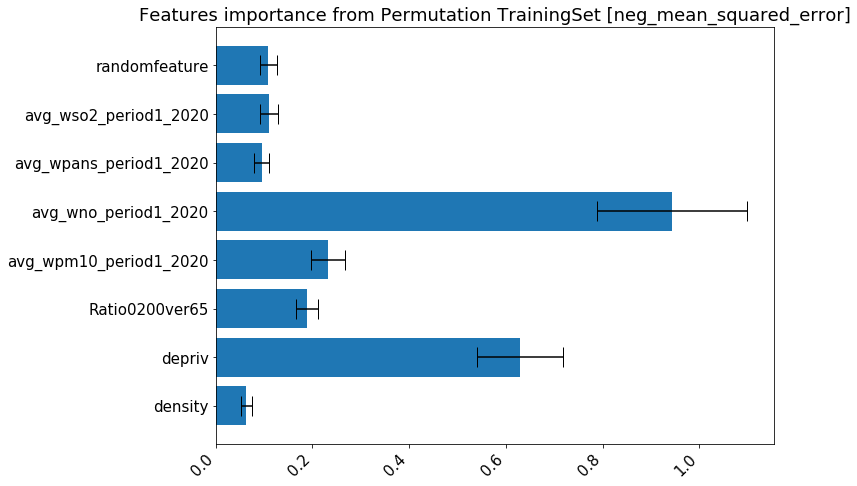

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        density, Score: 0.02936 +/- 0.00484
Feature:                         depriv, Score: 0.29031 +/- 0.04125
Feature:                 Ratio0200ver65, Score: 0.08721 +/- 0.01055
Feature:         avg_wpm10_period1_2020, Score: 0.10750 +/- 0.01625
Feature:           avg_wno_period1_2020, Score: 0.43538 +/- 0.07171
Feature:         avg_wpans_period1_2020, Score: 0.04382 +/- 0.00751
Feature:          avg_wso2_period1_2020, Score: 0.05110 +/- 0.00866
Feature:                  randomfeature, Score: 0.05007 +/- 0.00826


<Figure size 432x288 with 0 Axes>

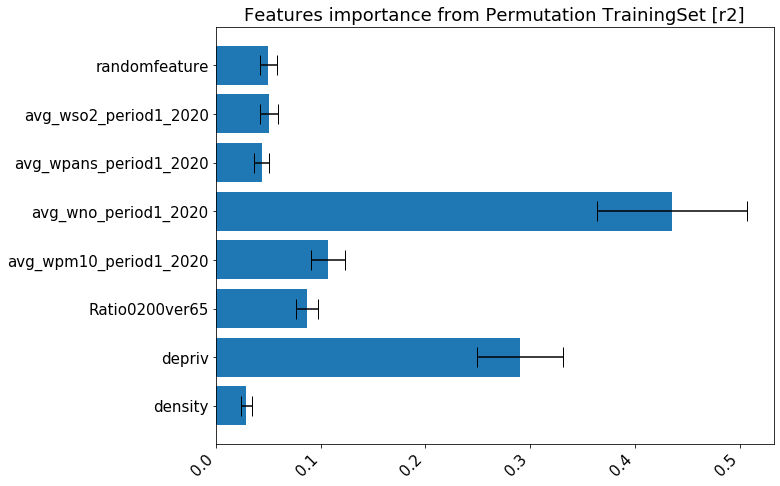

<Figure size 720x720 with 0 Axes>

In [8]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_nooverfit (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
    plotname="rf_model_nolat_nocommut_optoverfit", showplot=True, optimisedparams=besthyperF)

A seguire cercando di minimizzare invece RMSE su intero set

In [9]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_rmse)
import pprint

#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
    plotname="rf_model_allfeatures_optoallset", showplot=True, optimisedparams=besthyperF)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_rmse)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
    plotname="rf_model_nolat_optallset", showplot=True, optimisedparams=besthyperF )

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_rmse)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
    plotname="rf_model_nolat_nocommut_optallset", showplot=True, optimisedparams=besthyperF)

Qui invece ottimizzado RMSE sul testset

In [ ]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
    plotname="rf_model_allfeatures_opttestset", showplot=True, optimisedparams=besthyperF)

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
    plotname="rf_model_nolat_opttestset", showplot=True, optimisedparams=besthyperF )

In [ ]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
    plotname="rf_model_nolat_nocommut_opttestset", showplot=True, optimisedparams=besthyperF)